# Models > Logistic Regression

<div class="alert alert-info">Estimate a Logistic regression model for binary classification</div>

In [1]:
import polars as pl
import pyrsm as rsm

In [2]:
## setup pyrsm for autoreload
%reload_ext autoreload
%autoreload 2
%aimport pyrsm

### Example

As an example we will use a dataset that describes the survival status of individual passengers on the Titanic. The principal source for data about Titanic passengers is the Encyclopedia Titanic. One of the original sources is Eaton & Haas (1994) Titanic: Triumph and Tragedy, Patrick Stephens Ltd, which includes a passenger list created by many researchers and edited by Michael A. Findlay. Suppose we want to investigate which factors are most strongly associated with the chance of surviving the sinking of the Titanic. Lets focus on four variables in the database:

- survived = a factor with levels `Yes` and `No`
- pclass = Passenger Class (1st, 2nd, 3rd). This is a proxy for socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower
- sex = Sex (female, male)
- age = Age in years

Select `survived` as the response variable and `Yes` in **Choose level**. Select `pclass`, `sex` and `age` as the explanatory variables. In the screenshot below we see that each of the coefficients is statistically significant (p.value < .05) and that the model has some predictive power (Chi-squared statistic < .05). Unfortunately the coefficients from a logistic regression model are difficult to interpret. The `OR` column provides estimated odds-ratios. We see that the odds of survival were significantly lower for 2nd and 3rd class passengers compared to 1st class passenger. The odds of survival for males were also lower than for females. While the effect of age is statically significant, for each extra year in age the odds of survival are not as strongly affected (see also the standardized coefficient).

For each of the explanatory variables the following null and alternate hypotheses can be formulated for the odds ratios:

* H0: The odds-ratio associated with explanatory variable x is equal to 1
* Ha: The odds-ratio associated with explanatory variable x is not equal to 1

The odds-ratios from the logistic regression can be interpreted as follows:

- Compared to 1st class passengers, the odds of survival for 2nd class passengers was 72% lower, keeping all other variables in the model constant.
- Compared to 1st class passengers, the odds of survival for 3rd class passengers was 89.8% lower, keeping all other variables in the model constant.
- Compared to female passengers, the odds of survival for male passengers was 91.7% lower, keeping all other variables in the model constant.
- For an increase in passenger age of 1 year the odds of survival decreased by 3.4%, keeping all other variables in the model constant.


In [3]:
titanic = pl.read_parquet("https://github.com/radiant-ai-hub/pyrsm/raw/refs/heads/main/examples/data/data/titanic.parquet")
titanic

pclass,survived,sex,age,sibsp,parch,fare,name,cabin,embarked
enum,enum,enum,f64,i32,i32,f64,str,str,enum
"""1st""","""Yes""","""female""",29.0,0,0,211.337494,"""Allen, Miss. Elisabeth Walton""","""B5""","""Southampton"""
"""1st""","""Yes""","""male""",0.9167,1,2,151.550003,"""Allison, Master. Hudson Trevor""","""C22 C26""","""Southampton"""
"""1st""","""No""","""female""",2.0,1,2,151.550003,"""Allison, Miss. Helen Loraine""","""C22 C26""","""Southampton"""
"""1st""","""No""","""male""",30.0,1,2,151.550003,"""Allison, Mr. Hudson Joshua Cre…","""C22 C26""","""Southampton"""
"""1st""","""No""","""female""",25.0,1,2,151.550003,"""Allison, Mrs. Hudson J C (Bess…","""C22 C26""","""Southampton"""
…,…,…,…,…,…,…,…,…,…
"""3rd""","""No""","""male""",45.5,0,0,7.2249999,"""Youseff, Mr. Gerious""","""""","""Cherbourg"""
"""3rd""","""No""","""female""",14.5,1,0,14.4542,"""Zabour, Miss. Hileni""","""""","""Cherbourg"""
"""3rd""","""No""","""male""",26.5,0,0,7.2249999,"""Zakarian, Mr. Mapriededer""","""""","""Cherbourg"""


In [4]:
rsm.md("https://raw.githubusercontent.com/radiant-ai-hub/pyrsm/refs/heads/main/examples/data/data/titanic_description.md")

## Titanic

This dataset describes the survival status of individual passengers on the Titanic. The titanic data frame does not contain information from the crew, but it does contain actual ages of (some of) the passengers. The principal source for data about Titanic passengers is the Encyclopedia Titanica. One of the original sources is Eaton & Haas (1994) Titanic: Triumph and Tragedy, Patrick Stephens Ltd, which includes a passenger list created by many researchers and edited by Michael A. Findlay.

## Variables

* survival - Survival (Yes, No)
* pclass - Passenger Class (1st, 2nd, 3rd)
* sex - Sex (female, male)
* age - Age in years
* sibsp - Number of Siblings/Spouses Aboard
* parch - Number of Parents/Children Aboard
* fare - Passenger Fare
* name - Name
* cabin - Cabin
* embarked - Port of Embarkation (Cherbourg, Queenstown, Southampton)

##  Notes

`pclass` is a proxy for socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1). If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch) some relations were ignored.  The following are the definitions used for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins, nephews/nieces, aunts/uncles, and in-laws. Some children travelled only with a nanny, therefore parch=0 for them.  As well, some travelled with very close friends or neighbors in a village, however, the definitions do not support such relations.

Note: Missing values and the `ticket` variable were removed from the data

## Related reading

<a href="http://phys.org/news/2012-07-shipwrecks-men-survive.html" target="_blank">In shipwrecks, men more likely to survive</a>

In [5]:
titanic.head()

pclass,survived,sex,age,sibsp,parch,fare,name,cabin,embarked
enum,enum,enum,f64,i32,i32,f64,str,str,enum
"""1st""","""Yes""","""female""",29.0,0,0,211.337494,"""Allen, Miss. Elisabeth Walton""","""B5""","""Southampton"""
"""1st""","""Yes""","""male""",0.9167,1,2,151.550003,"""Allison, Master. Hudson Trevor""","""C22 C26""","""Southampton"""
"""1st""","""No""","""female""",2.0,1,2,151.550003,"""Allison, Miss. Helen Loraine""","""C22 C26""","""Southampton"""
"""1st""","""No""","""male""",30.0,1,2,151.550003,"""Allison, Mr. Hudson Joshua Cre…","""C22 C26""","""Southampton"""
"""1st""","""No""","""female""",25.0,1,2,151.550003,"""Allison, Mrs. Hudson J C (Bess…","""C22 C26""","""Southampton"""


The two code chunks below test if the categorical order set by the user or data owner is maintained throughout the analysis.

In [6]:
levels = titanic["pclass"].dtype.categories.to_list()
levels

['1st', '2nd', '3rd']

In [7]:
levels.reverse()
titanic = titanic.with_columns(
    pl.col("pclass").cast(pl.Enum(levels))
)
levels = titanic["pclass"].dtype.categories.to_list()
levels

['3rd', '2nd', '1st']

In [8]:
clf = rsm.model.logistic(
    {"titanic": titanic}, rvar="survived", lev="Yes", evar=["pclass", "sex", "age"]
)
clf.summary()

Logistic regression (GLM)
Data                 : titanic
Response variable    : survived
Level                : Yes
Explanatory variables: pclass, sex, age
Null hyp.: There is no effect of x on survived
Alt. hyp.: There is an effect of x on survived

┌─────────────┬───────┬────────┬─────────────┬───────────┬─────────┬─────────┬─────┐
│ index       ┆ OR    ┆ OR%    ┆ coefficient ┆ std.error ┆ z.value ┆ p.value ┆     │
╞═════════════╪═══════╪════════╪═════════════╪═══════════╪═════════╪═════════╪═════╡
│ Intercept   ┆ 3.428 ┆ 242.8% ┆ 1.232       ┆ 0.209     ┆ 5.881   ┆ < .001  ┆ *** │
│ pclass[2nd] ┆ 2.741 ┆ 174.1% ┆ 1.008       ┆ 0.198     ┆ 5.086   ┆ < .001  ┆ *** │
│ pclass[1st] ┆ 9.804 ┆ 880.4% ┆ 2.283       ┆ 0.226     ┆ 10.104  ┆ < .001  ┆ *** │
│ sex[male]   ┆ 0.083 ┆ -91.7% ┆ -2.491      ┆ 0.166     ┆ -14.996 ┆ < .001  ┆ *** │
│ age         ┆ 0.966 ┆ -3.4%  ┆ -0.034      ┆ 0.006     ┆ -5.437  ┆ < .001  ┆ *** │
└─────────────┴───────┴────────┴─────────────┴───────────┴─────────┴─

In [9]:
pred = clf.predict(ci=True)
pred

pclass,sex,age,prediction,2.50%,97.50%
enum,enum,f64,f64,f64,f64
"""1st""","""female""",29.0,0.925157,0.891581,0.948931
"""1st""","""male""",0.9167,0.729419,0.603584,0.826774
"""1st""","""female""",2.0,0.969104,0.944014,0.983151
"""1st""","""male""",30.0,0.497163,0.416806,0.577666
"""1st""","""female""",25.0,0.934167,0.902308,0.956141
…,…,…,…,…,…
"""3rd""","""male""",45.5,0.055792,0.037692,0.081846
"""3rd""","""female""",14.5,0.675213,0.60441,0.738819
"""3rd""","""male""",26.5,0.102161,0.078134,0.132515


In [10]:
clf.summary(test="pclass")

Logistic regression (GLM)
Data                 : titanic
Response variable    : survived
Level                : Yes
Explanatory variables: pclass, sex, age
Null hyp.: There is no effect of x on survived
Alt. hyp.: There is an effect of x on survived

┌─────────────┬───────┬────────┬─────────────┬───────────┬─────────┬─────────┬─────┐
│ index       ┆ OR    ┆ OR%    ┆ coefficient ┆ std.error ┆ z.value ┆ p.value ┆     │
╞═════════════╪═══════╪════════╪═════════════╪═══════════╪═════════╪═════════╪═════╡
│ Intercept   ┆ 3.428 ┆ 242.8% ┆ 1.232       ┆ 0.209     ┆ 5.881   ┆ < .001  ┆ *** │
│ pclass[2nd] ┆ 2.741 ┆ 174.1% ┆ 1.008       ┆ 0.198     ┆ 5.086   ┆ < .001  ┆ *** │
│ pclass[1st] ┆ 9.804 ┆ 880.4% ┆ 2.283       ┆ 0.226     ┆ 10.104  ┆ < .001  ┆ *** │
│ sex[male]   ┆ 0.083 ┆ -91.7% ┆ -2.491      ┆ 0.166     ┆ -14.996 ┆ < .001  ┆ *** │
│ age         ┆ 0.966 ┆ -3.4%  ┆ -0.034      ┆ 0.006     ┆ -5.437  ┆ < .001  ┆ *** │
└─────────────┴───────┴────────┴─────────────┴───────────┴─────────┴─

In addition to the numerical output provided in the _Summary_ tab we can also evaluate the link between `survival`, `class`, `sex`, and `age` visually (see _Plot_ tab). In the screenshot below we see a coefficient (or rather an odds-ratio) plot with confidence intervals. The relative importance of gender and class compared to age clearly stands out. Note: click the check box for standardized coefficients (i.e., `standardize`) in the _Summary_ tab and see if your conclusion changes.


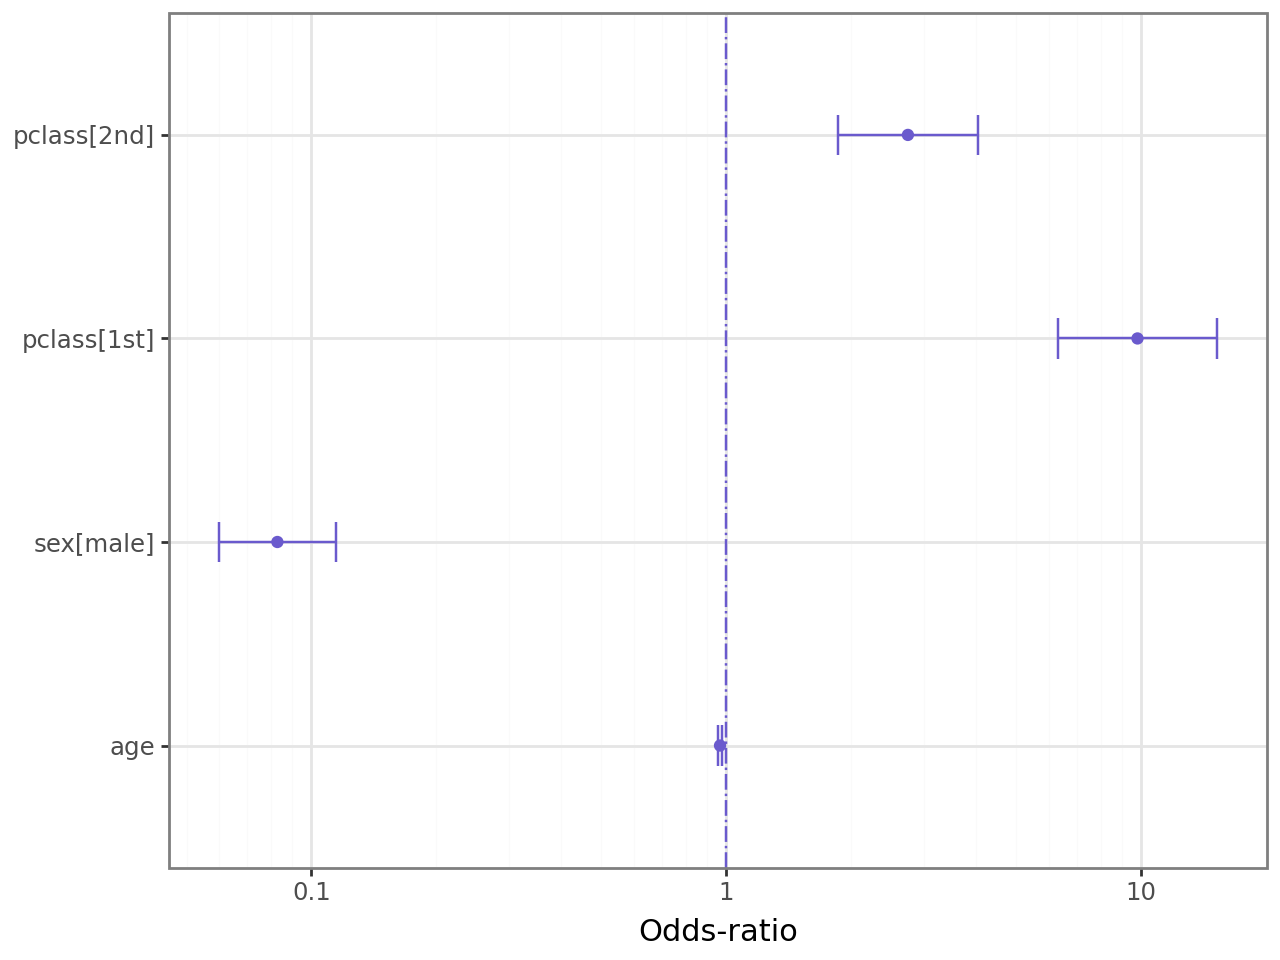

In [11]:
clf.plot(plots="or")

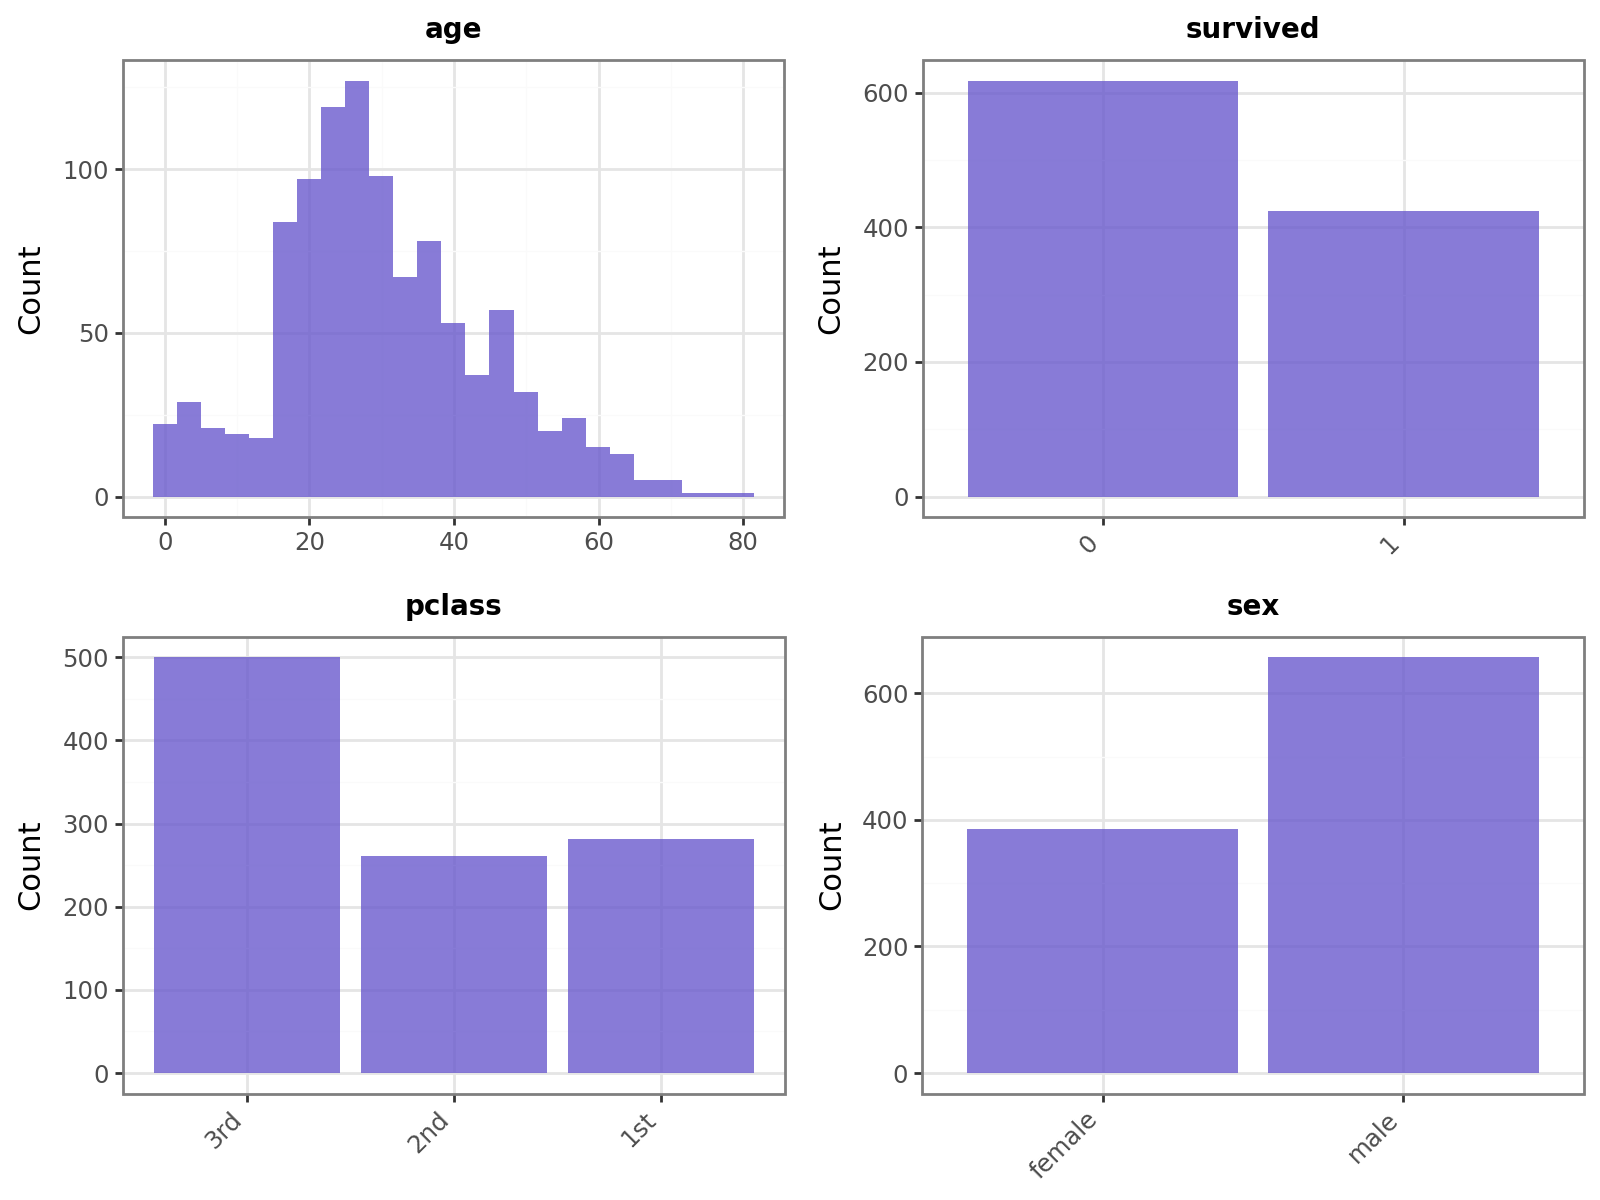

In [12]:
clf.plot("dist")

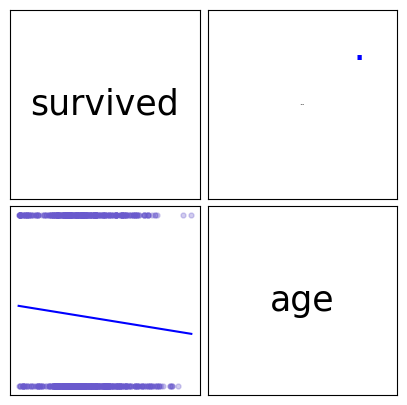

In [13]:
clf.plot(plots="corr")

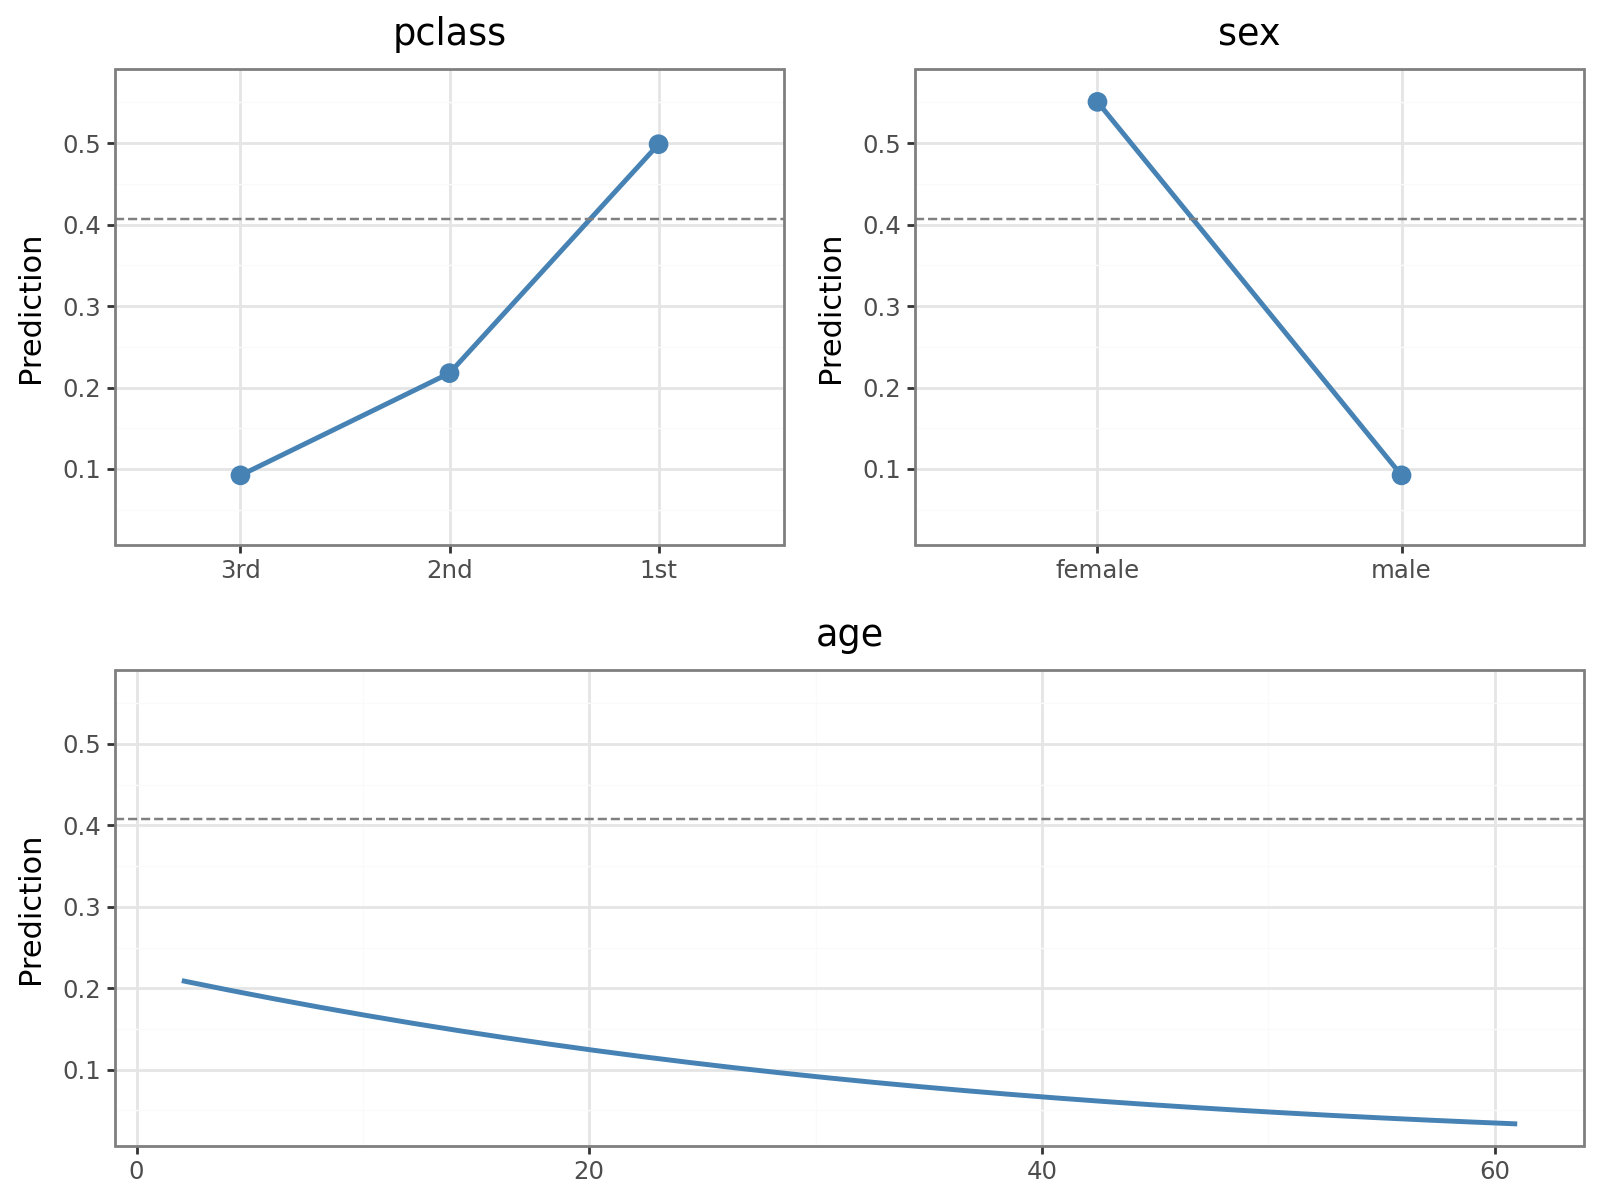

In [14]:
clf.plot("pred")

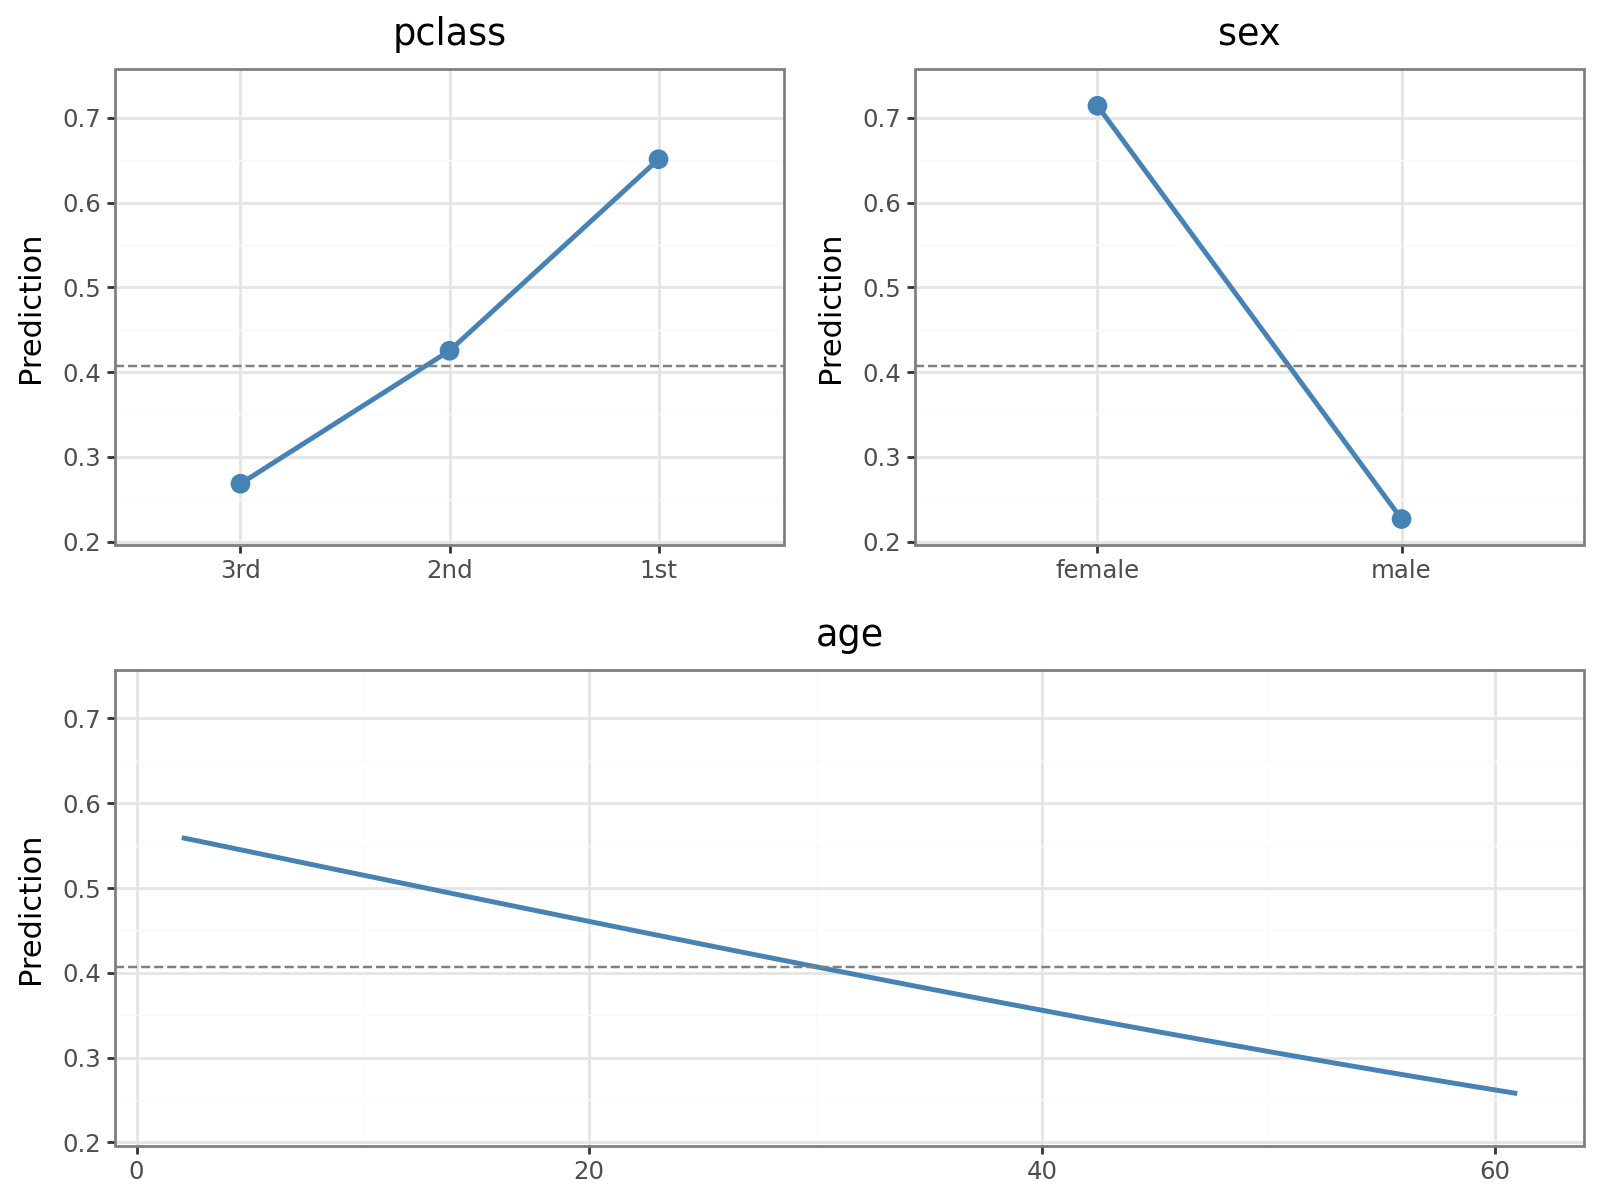

In [15]:
clf.plot("pdp")

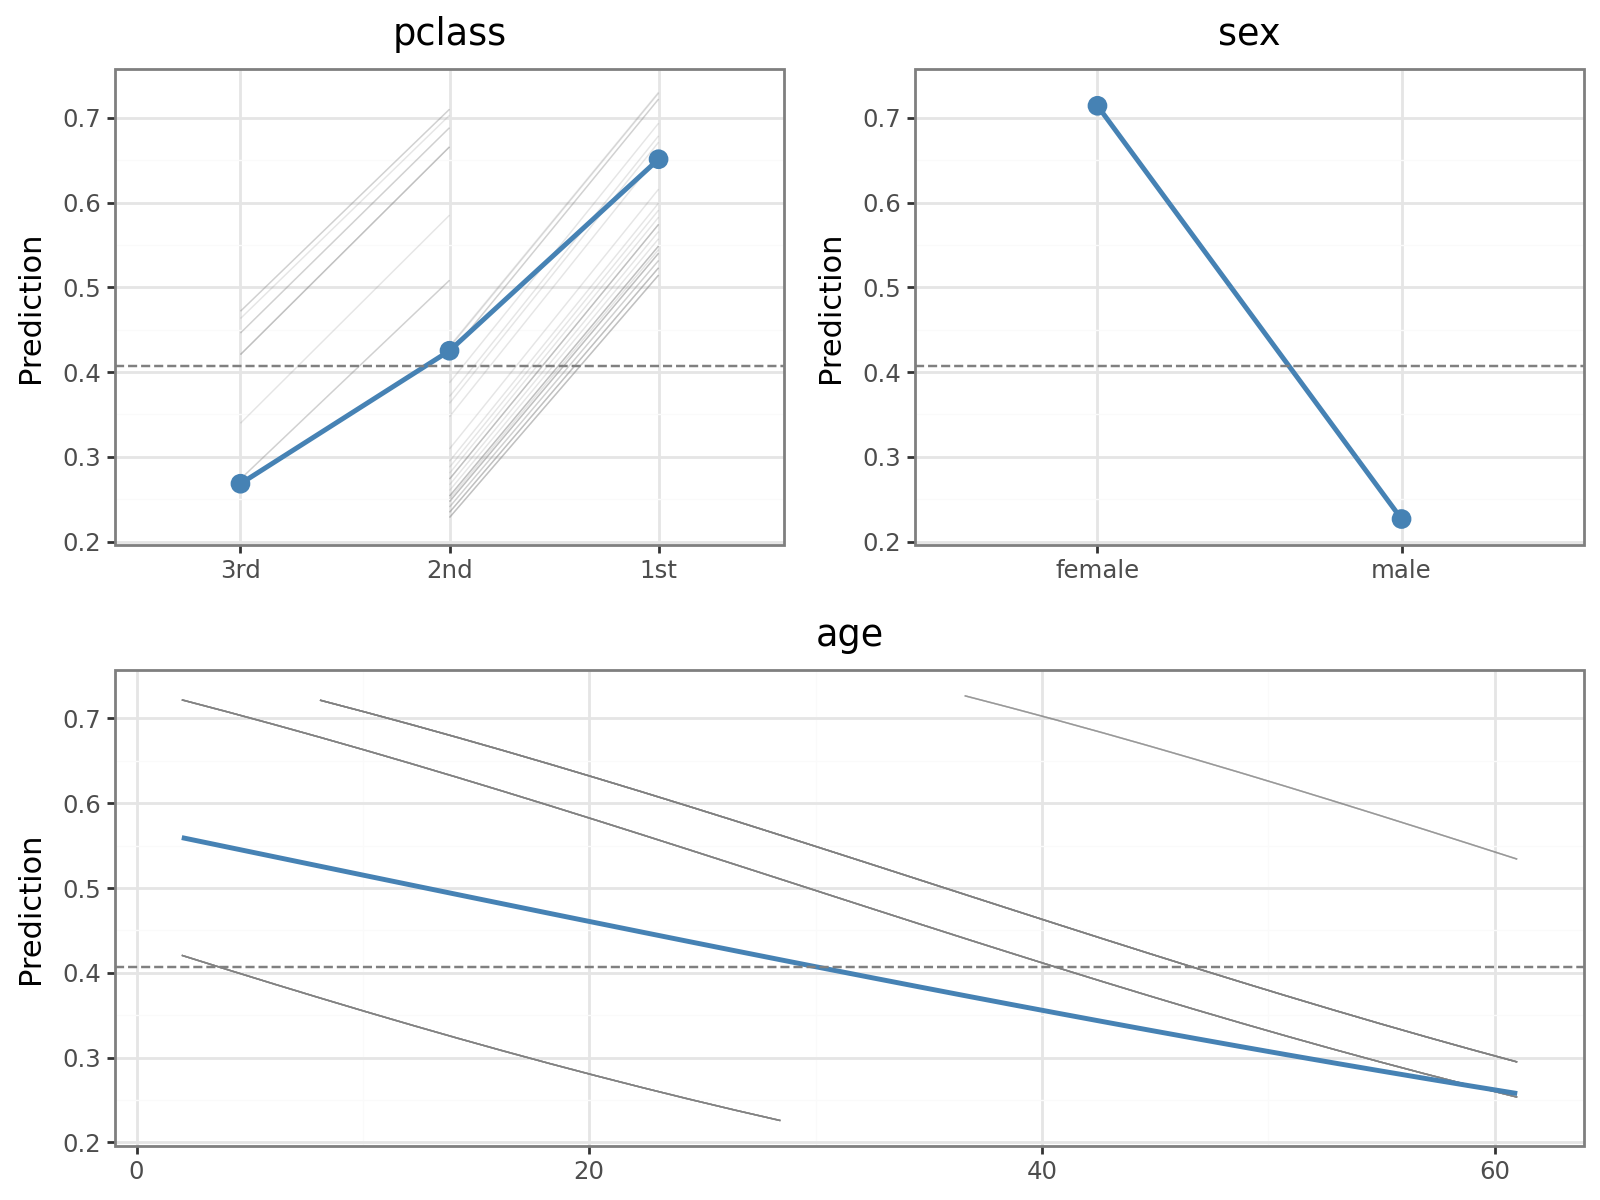

In [16]:
clf.plot("pdp", ice=True)

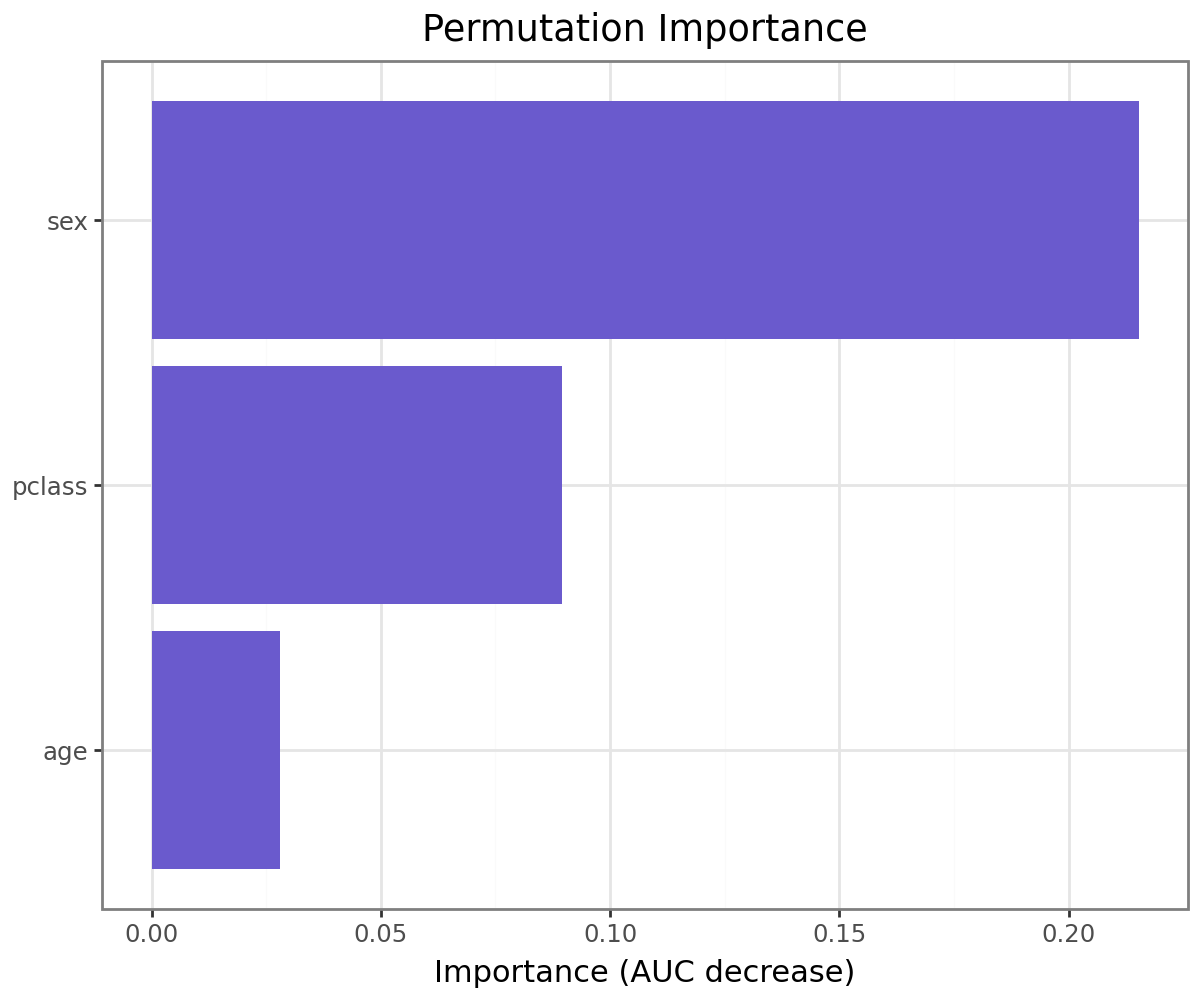

In [17]:
clf.plot("pip")

In [18]:
pip_values = clf.plot(plots="pip", ret=True)
pip_values

variable,importance
str,f64
"""sex""",0.215279
"""pclass""",0.089433
"""age""",0.028053


© Vincent Nijs (2026)